In [1]:
import pandas as pd
import requests
from gensim.models import KeyedVectors
import json
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patchesb
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [2]:
file_data = json.load(open("../data/ServiceAccountsKey.json"))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")

In [3]:
filtered_vocab_df = pd.read_json("../data/filtered_vocab_df.json")
filtered_vocab_df.head(20)

,word,1501-1550,1551-1600,1601-1650,1651-1700,mean,in_lila_embeddings,in_lasla,in_operamaiora,transl
5018,dico,42831,120825,41832,72221,69427.25,True,True,True,"say, call, tell"
6155,omnis,33152,108530,46009,66387,63519.50,True,True,True,
2515,facio,33323,109486,40134,53953,59224.00,True,True,True,"do, make, handle"
4040,pars,32591,90667,43593,51249,54525.00,True,True,True,part
6769,habeo,30884,87225,38386,57791,53571.50,True,True,True,"have, hold, possess, consider, think"
364,possum,23869,79572,36898,72892,53307.75,True,True,True,"be able, can"
897,res,27869,68790,27473,49014,43286.50,True,True,True,suddenly
4810,suus,23716,58975,33267,52441,42099.75,True,True,True,"his own, her own, its own, their own"
2392,uideo,21389,60143,28355,54288,41043.75,True,True,True,
1790,magnus,23446,61213,29708,39211,38394.50,True,True,True,"big, great"


In [4]:
len(filtered_vocab_df)

6332

In [5]:
word_transl_dict = dict(zip(filtered_vocab_df["word"], filtered_vocab_df["transl"]))

In [6]:
filtered_vocab_df[filtered_vocab_df["word"].str.contains("equa")]

,word,1501-1550,1551-1600,1601-1650,1651-1700,mean,in_lila_embeddings,in_lasla,in_operamaiora,transl
4035,aequalis,5934,20561,14458,17144,14524.25,True,True,True,"equal, similar, uniform, level, flat, of the s..."
5858,inaequalis,677,2151,1425,1543,1449.00,True,True,True,"uneven, unequal, not smooth/level (surface), i..."
5961,aequalitas,368,1475,710,1031,896.00,True,True,True,"evenness, equality (of age/status/merit/distri..."
311,inaequalitas,669,876,754,1259,889.50,True,True,True,"irregularity of shape/distribution, patchiness..."
6838,sequax,61,69,45,33,52.00,True,True,True,"that follows closely/eagerly, addicted, pliant..."
1973,nequam,16,80,36,45,44.25,True,True,True,"who, which, whom, that"
2833,antequam,9,30,20,41,25.00,True,True,True,"before, sooner than, until"
7017,nequaquam,9,40,19,19,21.75,True,True,True,(1.) by no means (2.) by no means (3.) by no m...


In [7]:
# translation function if we need to translate some other words
def simple_translation(target):
    try:
        base_url = "https://www.latin-is-simple.com/api/vocabulary/search/?query={}&forms_only=true"
        resp_json = requests.get(base_url.format(target)).json()
        transl = resp_json[0]["translations_unstructured"]["en"]
        if transl == "still in translation":
            transl = ""
        return transl
    except:
        return ""

In [8]:
periods_str = filtered_vocab_df.columns[1:5]
periods_str

Index(['1501-1550', '1551-1600', '1601-1650', '1651-1700'], dtype='object')

In [9]:
# load all 6 vector models
# (2 from LiLa, 4 trained by us on noscemus)

lasla = KeyedVectors.load_word2vec_format("../data/large_data/allLASLA-lemmi-fast-100-SKIP-win5-min5.vec")
operamaiora = KeyedVectors.load_word2vec_format("../data/large_data/opera-maiora-lemmas_skip_100.vec")

In [10]:
vectors_dict = {}
for per_str in periods_str:
    vectors_dict[per_str] = KeyedVectors.load("../data/large_data/vectors_{}.wv".format(per_str))

In [11]:
def nn_tups_to_transl(nn_tups, shorten_transl=True):
    transl_list = []
    for tup in nn_tups:
        try:    
            transl = word_transl_dict[tup[0]]
        except:
            try: 
                transl = simple_translation(tup[0])
            except:
                transl = ""
        if shorten_transl:
            if len(transl) >= 10:
                transl = transl[:10] + "..."
        transl_list.append(tup[0] + " ({})".format(transl))
    #transl_list = [tup[0] + " ({})".format(word_transl_dict[tup[0]]) for tup in nn_tups]
    transl_list = [e.replace(" ()", "") for e in transl_list]
    return transl_list

In [12]:
nn_tups_to_transl(lasla.most_similar("equus"), shorten_transl=False)

['currus (chariot, light horse vehicle, triumphal chariot, triumph, wheels on plow, cart)',
 'equa (mare)',
 'equito (ride (horseback))',
 'calcar (spur (for horse), spur, incitement, stimulus, spur of a cock)',
 'ceruus',
 'freno (brake, curb, restrain, check)',
 'habena (thong, strap, whip, halter, reins (pl.), direction, management, government)',
 'essedum (war chariot (two wheeled), light traveling carriage)',
 'frenum (bridle/harness/rein/bit, harnessed horses/team, check/restraint/brake, mastery)',
 'frendo (gnash the teeth, grind up small)']

In [13]:
target = "equus"
topn=10
most_similar_by_per = {}
most_similar_by_per["lasla"] = nn_tups_to_transl(lasla.most_similar(target, topn=topn))
most_similar_by_per["operamaiora"] = nn_tups_to_transl(operamaiora.most_similar(target, topn=topn), shorten_transl=False)
for per_str in periods_str:
    nns= nn_tups_to_transl(vectors_dict[per_str].most_similar(target, topn=topn), shorten_transl=False)
    most_similar_by_per[per_str] = nns
nns_equus = pd.DataFrame(most_similar_by_per)
nns_equus

,lasla,operamaiora,1501-1550,1551-1600,1601-1650,1651-1700
0,"currus (chariot, l...)","asinus (of/connected with an ass/donkey, ass's...","camelus (camel, dromedary)","asinus (of/connected with an ass/donkey, ass's...","bos (ox, steer, cow)","asinus (of/connected with an ass/donkey, ass's..."
1,equa (mare),eques (horseman),"asini (of/connected with an ass/donkey, ass's,...",mulus (mule),canis (dog),"currus (chariot, light horse vehicle, triumpha..."
2,equito (ride (hors...),"bos (ox, steer, cow)","currus (chariot, light horse vehicle, triumpha...","bos (ox, steer, cow)",mulus (mule),"bos (ox, steer, cow)"
3,calcar (spur (for ...),"bipes (two-footed, bipedal, on two feet (of qu...","asinus (of/connected with an ass/donkey, ass's...","currus (chariot, light horse vehicle, triumpha...","currus (chariot, light horse vehicle, triumpha...",mulus (mule)
4,ceruus,"domus (house, home (NB 3 special uses and endi...",canis (dog),iumentum (Baggage Animal),"asinus (of/connected with an ass/donkey, ass's...",eques (horseman)
5,"freno (brake, cur...)","trituro (rub, wear away, wear out, tread)","bos (ox, steer, cow)","camelus (camel, dromedary)","camelus (camel, dromedary)","canus (white, gray, aged, old, wise, hoary, fo..."
6,"habena (thong, str...)",mercatio,"pecus (herd, flock, cattle, sheep, farm animal...",eques (horseman),"grex (flock, herd, crowd)","ungula (hoof, bird claw/talon, toe nail, pig's..."
7,essedum (war chario...),"equester (knight, one of equestrian order/clas...","ungula (hoof, bird claw/talon, toe nail, pig's...",canis (dog),lupus (wolf),canis (dog)
8,frenum (bridle/har...),iumentum (Baggage Animal),mulus (mule),"certamen (contest, competition, battle, combat...","curru (chariot, light horse vehicle, triumphal...",ceruus
9,frendo (gnash the ...),"animalis (a living creature, animal)",iumentum (Baggage Animal),lupus (wolf),"ferox (wild, bold, warlike, cruel, defiant, ar...","curru (chariot, light horse vehicle, triumphal..."


In [15]:
#set_with_dataframe(noscemus_gs.add_worksheet("nns_equus_v1", 1,1), nns_equus)

In [18]:
target = "fecundus"
topn=10
most_similar_by_per = {}
most_similar_by_per["lasla"] = nn_tups_to_transl(lasla.most_similar(target, topn=topn), shorten_transl=False)
most_similar_by_per["operamaiora"] = nn_tups_to_transl(operamaiora.most_similar(target, topn=topn),  shorten_transl=False)
for per_str in periods_str:
    nns= nn_tups_to_transl(vectors_dict[per_str].most_similar(target, topn=topn), shorten_transl=False)
    most_similar_by_per[per_str] = nns
nns_fecundus = pd.DataFrame(most_similar_by_per)
nns_fecundus

,lasla,operamaiora,1501-1550,1551-1600,1601-1650,1651-1700
0,fecunditas (fruitfulness),fecundo (make fertile/fruitful),foecundus,fecunditas (fruitfulness),fecunditas (fruitfulness),fecunditas (fruitfulness)
1,"rubicundus (suffused with red, ruddy)",fecunditas (fruitfulness),fecunditas (fruitfulness),foecundus,foecundus,foecundus
2,"oriundus (descended, originating from)",regeneratiuus,natura (nature),"procreo (procreate, give birth)","parens (be obedient, obey)",semen (seed)
3,"facundus (eloquent, fluent, able to express el...","sterilis (barren, sterile, fruitless, unprofit...","generatio (generation, action/process of procr...","proles (offspring, descendant, that springs by...","parentes (be obedient, obey)","nascor ((1.) be born (2.) spring forth, arise)"
4,grauidus,"regeneratio (regeneration, being born again, [...",tus (frankincense),"produco (lead forward, bring out, reveal, indu...",semen (seed),insideo (sit on)
5,uertumnus,infantilis (infantile),ulterior (further),iungo (connect),"alienigenus (different, foreign, alien, of/bor...","secundus (second, favorable)"
6,tantalis,"regenero (beget, father, produce, procreate, s...","pluribus (much, many)",uirginitas,"genitor (father, creator, originator)","exsisto (exist, emerge)"
7,pirus (pear-tree),"carnalis (carnal, fleshy, bodily, sensual, of ...","aptus (suitable, adapted, ready, apt, proper, ...","perfectus (complete, finish, execute, bring ab...",prouentus (Wind),"semens (mind, spirit)"
8,"ferax (fruitful, fertile. prolific)",philippus (Philip (name of several Macedonian ...,nis,"multiplex (having many twists/turns, having ma...","utpote (namely, since, as, in as much as, inas...",creo (create)
9,herbidus (grassy),"infans (speechless, inarticulate, new born, ch...","concipio (take in/up, receive, catch, derive/d...","sterilis (barren, sterile, fruitless, unprofit...","germen (sprout, bud, shoot)","primus (first, foremost, chief, principal)"


In [ ]:
#set_with_dataframe(noscemus_gs.add_worksheet("nns_seminarium_v1", 1,1), nns_seminarium)

In [19]:
target = "scientia"
topn=10
most_similar_by_per = {}
most_similar_by_per["lasla"] = nn_tups_to_transl(lasla.most_similar(target, topn=topn), shorten_transl=False)
most_similar_by_per["operamaiora"] = nn_tups_to_transl(operamaiora.most_similar(target, topn=topn), shorten_transl=False)
for per_str in periods_str:
    nns= nn_tups_to_transl(vectors_dict[per_str].most_similar(target, topn=topn), shorten_transl=False)
    most_similar_by_per[per_str] = nns
nns_scientia = pd.DataFrame(most_similar_by_per)
nns_scientia

,lasla,operamaiora,1501-1550,1551-1600,1601-1650,1651-1700
0,"inscientia (unknowing, unaware)","scibilis (knowable, discernible)","cognitio (examination, inquiry/investigation (...","mathematicus (mathematical, astrological)","cognitio (examination, inquiry/investigation (...","cognitio (examination, inquiry/investigation (..."
1,"experientia (try, test, experience)",scio (know),"disciplina (teaching, instruction, education, ...",philosophia (philosophy),philosophia (philosophy),"disciplina (teaching, instruction, education, ..."
2,sapientia ((1.) have good taste (2.) have good...,"scientificus (scientific, learned)","ars (art, skill)","cognitio (examination, inquiry/investigation (...","disciplina (teaching, instruction, education, ...","notitia (notice, acquaintance, knowledge)"
3,prudentia (wisdom),"nescientia (not to know, be ignorant)",philosophia (philosophy),"ars (art, skill)","mathematicus (mathematical, astrological)",philosophia (philosophy)
4,"conscientia (feel guilty, be conscious of (wro...",producibilis,"mathematicus (mathematical, astrological)","disciplina (teaching, instruction, education, ...","contemplatio (view, survey, taking aim, contem...","ars (art, skill)"
5,"intelligentia (understand, realize)","cognitio (examination, inquiry/investigation (...","doctrina (education, learning, science, teachi...",ueritas,geometria (geometry),"doctrina (education, learning, science, teachi..."
6,"elegantia (elegant, fine, handsome, tasteful, ...",indemonstrabilis (demonstrable),scio (know),sapientia ((1.) have good taste (2.) have good...,"ars (art, skill)",geometria (geometry)
7,prouidentia,reducibilis,"necessarius (necessary, needed, essential, ind...",philosophus (philosopher),"doctrina (education, learning, science, teachi...","mathematicus (mathematical, astrological)"
8,"indigentia (need, lack, require (w/GEN or ABL))",speculatiuus,sapientia ((1.) have good taste (2.) have good...,res (suddenly),sapientia ((1.) have good taste (2.) have good...,"peritia (practical knowledge, skill, expertise..."
9,"artificium (artwork, craft, skill)",demonstrabilis (demonstrable),"cognosco (become acquainted with, learn, recog...","doctrina (education, learning, science, teachi...",philosopho (philosopher),"studiosus (eager, keen, full of zeal, studious..."


In [ ]:
#set_with_dataframe(noscemus_gs.add_worksheet("nns_scientia_v1", 1,1), nns_scientia)

In [20]:
target = "scientia"
topn=10
most_similar_by_per = {}
special_words = []
special_words.extend([tup[0] for tup in lasla.most_similar(target, topn=topn)])
special_words.extend([tup[0] for tup in operamaiora.most_similar(target, topn=topn)])
for per_str in periods_str:
    special_words.extend([tup[0] for tup in vectors_dict[per_str].most_similar(target, topn=topn)])
special_words = np.array(list(set(special_words)))
len(special_words)

36

In [21]:
[el[0] for el in lasla.most_similar("sapientia")]

['sapiens',
 'scientia',
 'prudentia',
 'stoici',
 'experientia',
 'prouidentia',
 'sapienter',
 'fortuita',
 'perfectus',
 'sapio']

In [22]:
[el[0] for el in lasla.most_similar("cultura")]

['cultus',
 'uectura',
 'iunctura',
 'mercatura',
 'structura',
 'fructuosus',
 'ager',
 'culta',
 'uictus',
 'propagatio']

In [23]:
def get_tsne_coors(kv, perplexity=18):
    # inverse similarity to distance
    #data = (1 - sim_matrix) / 1
    words = np.array(kv.index_to_key)
    #data.round(5)
    # tSNE to project all words into a 2-dimensional space
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, metric='cosine', n_iter=1000) # dissimilarity="precomputed",
    #tsne = TSNE(n_components=2, random_state=42, perplexity=18, metric='precomputed', n_iter=5000) # dissimilarity="precomputed",
    pos = tsne.fit_transform(kv.vectors) # project all points into space
    xs, ys = pos[:, 0], pos[:, 1]
    # extract minimal and maximal values
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    return xs, ys, words

In [24]:
def rand_col():
    color = np.random.randint(0, 256, size=3)
    color = np.round(color / 256, 2)
    return tuple(color)

In [25]:
rand_col()

(0.0, 0.06, 0.1)

In [27]:
np.random.randint(0,360)

263

In [30]:
def draw_special_words(ax, wordlist, color):
    color_idx = [word[0] for word in enumerate(words) if word[1] in wordlist]
    if color == "random_color":
        for x,y,w in zip(xs[color_idx], ys[color_idx] - 0.003, words[color_idx]):
            ax.text(x,y,w, horizontalalignment='center', fontsize=5, color=rand_col(), zorder=3, rotation=np.random.randint(0,360))
    else:
        for x,y,w in zip(xs[color_idx], ys[color_idx] - 0.003, words[color_idx]):
            ax.text(x,y,w, horizontalalignment='center', fontsize=5, color=color, zorder=3, rotation=np.random.randint(0,360))

In [28]:
!mkdir ../figures/large_embeddings/

mkdir: ../figures/large_embeddings/: File exists


In [31]:
%%capture
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    xs, ys, words = get_tsne_coors(kv, perplexity=10)
    fig, ax = plt.subplots(1, 1, figsize=(24, 24), dpi=300, tight_layout=True)
    #ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    
    draw_special_words(ax=ax, wordlist=words, color="random_color")
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    fig.savefig("../figures/large_embeddings/embeddings_{}.png".format(key))

In [150]:
kv = vectors_dict["1651-1700"]
xs, ys, words = get_tsne_coors(kv, perplexity=10)

In [32]:
special_words = [tup[0] for tup in vectors_dict["1651-1700"].most_similar("scientia", topn=20)]
special_words

['cognitio',
 'disciplina',
 'notitia',
 'philosophia',
 'ars',
 'doctrina',
 'geometria',
 'mathematicus',
 'peritia',
 'studiosus',
 'eruditio',
 'sapientia',
 'res',
 'mathematicarum',
 'disco',
 'institutio',
 'cognitor',
 'profiteor',
 'moralis',
 'addisco']

In [33]:
vectors_dict["lasla"] = lasla
vectors_dict["operamaiora"] = operamaiora

In [35]:
['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']

dict_keys(['1501-1550', '1551-1600', '1601-1650', '1651-1700', 'lasla', 'operamaiora'])

In [37]:
kv = vectors_dict["lasla"]
xs, ys, words = get_tsne_coors(kv, perplexity=4)
ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)

In [44]:
positions_dict = {}
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    positions_dict[key] = get_tsne_coors(kv, perplexity=8)

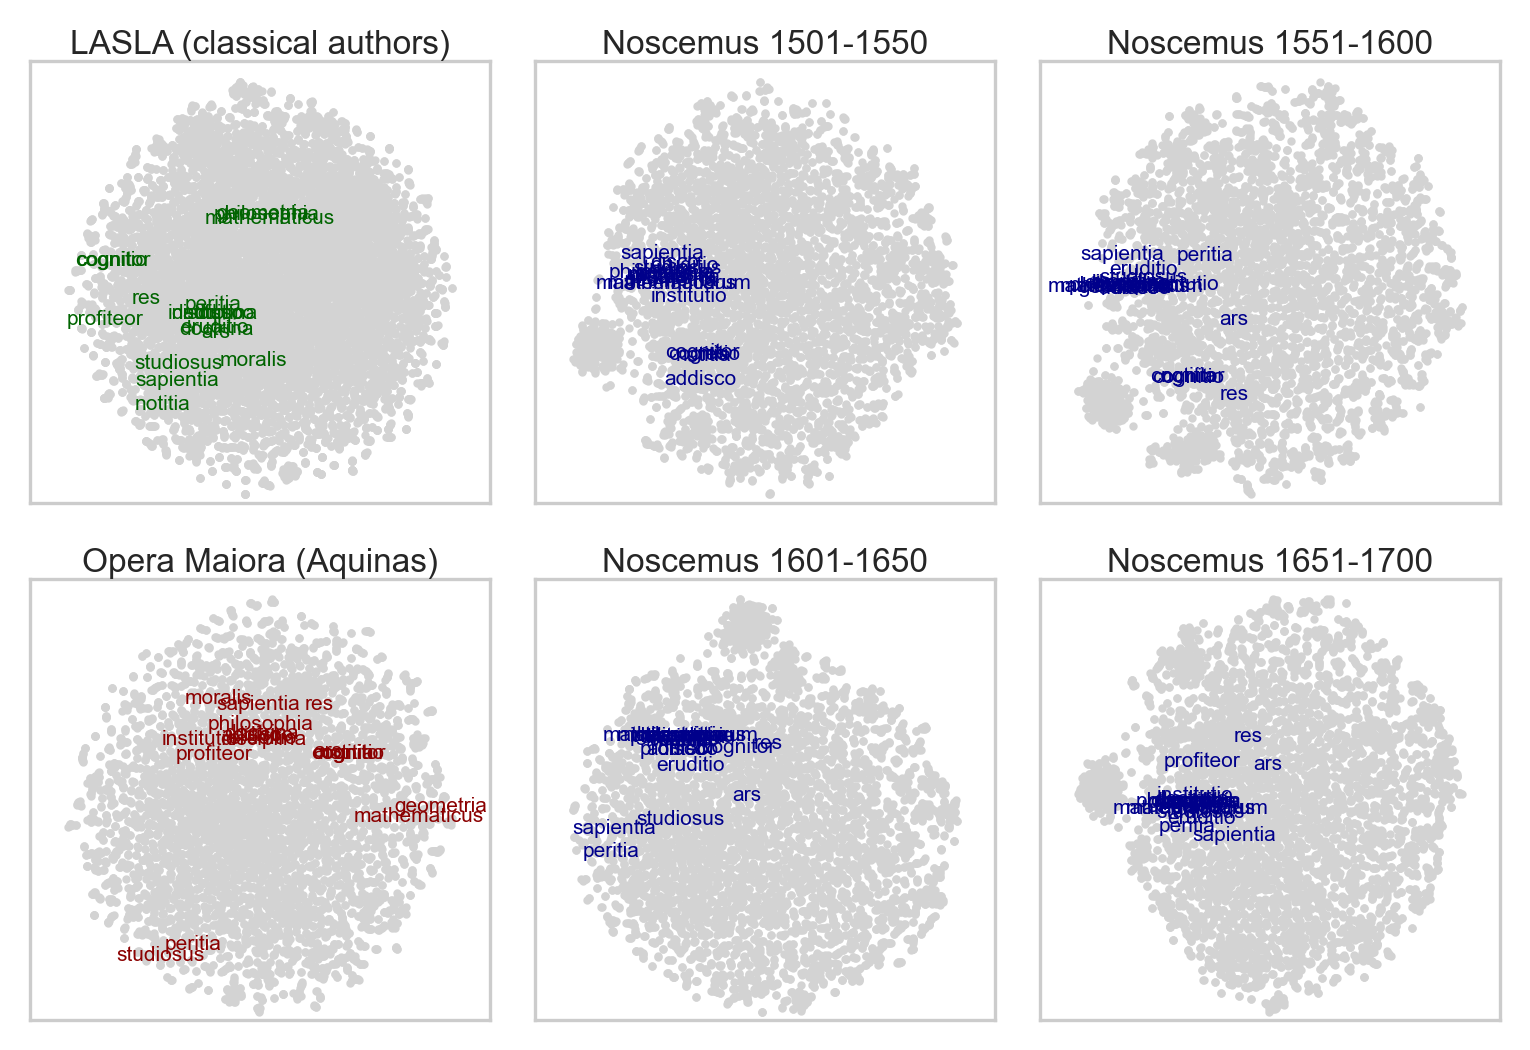

In [51]:
fig, axs = plt.subplots(2,3, figsize=(5.2, 3.6), dpi=300, tight_layout=True)

for ax,key in zip(axs.ravel(), ['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']):
    if key == "lasla":
        title = "LASLA (classical authors)"
        color = "darkgreen"
    elif key == "operamaiora":
        title = "Opera Maiora (Thomas Aquinas)"
        color = "darkred"
    else:
        title = "Noscemus {}".format(key)
        color="darkblue"
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    special_words_filtered = [w for w in special_words if w in words]
    draw_special_words(ax=ax, wordlist=special_words_filtered, color=color)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.02,1.05)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if key == "lasla":
        title = "LASLA (classical authors)" 
    elif key == "operamaiora":
        title = "Opera Maiora (Aquinas)"
    else:
        title = "Noscemus {}".format(key) 
    ax.set_title(title, fontsize=8, pad=-12)

In [52]:
fig.savefig("../figures/embeddings_scientia.png")